### Set-up for evaluation stage 

In [1]:
# import some common libraries
import torch
import numpy as np
import os, json, random, cv2
import matplotlib.pyplot as plt

# Setup detectron2 
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# Import utilities for inference & evaluation
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer

In [2]:
# Load config and model weights
output_dir = "./output/"

cfg = get_cfg()
cfg.merge_from_file("config.yml") 
model = build_model(cfg) 

cfg.MODEL.WEIGHTS = os.path.join(output_dir, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
oks_sigmas = cfg.TEST.KEYPOINT_OKS_SIGMAS

### Register synthetic and real dataset

In [3]:
# Load serialized datasets
datasets_dict = {}

for d in (["train", "test", "real"]):    
    with open("dataset_dict_" + d + ".json") as f:
        datasets_dict[d] = json.load(f)
        
# Define function that returns corresponding list of dicts
def return_dataset(keyword):
    for key in datasets_dict:
        if key == keyword:
            return datasets_dict[key]

In [4]:
# Register synth and real datasets in DatasetCatalog
# Train is also needed for COCOEvaluation, otherwise an error is thrown
DatasetCatalog.clear()
MetadataCatalog.clear()

for d in ["train", "test", "real"]:
    DatasetCatalog.register("dataset_" + d, lambda d=d: return_dataset(d))
    MetadataCatalog.get("dataset_" + d).set(thing_classes=["robot_arm", "box"], 
                                        keypoint_names=["base", "joint_1", "joint_2", "tip", 
                                                        "top_front_left", "top_front_right", "top_back_left", "top_back_right"],
                                                # images are flipped in training process, so reeavulate!
                                        keypoint_flip_map=[("top_front_left", "top_front_right"), ("top_back_left", "top_back_right")],
                                        keypoint_connection_rules=[("base", "joint_1", (255,0,0)),
                                                                   ("joint_1", "joint_2", (0,255,0)),
                                                                   ("joint_2", "tip", (0,0,255)),
                                                                   ("top_front_left", "top_front_right", (255, 0, 0)),
                                                                   ("top_front_left", "top_back_left", (0, 255, 0)),
                                                                   ("top_back_left", "top_back_right", (0, 0, 255)),
                                                                   ("top_front_right", "top_back_right", (255, 255, 0))])

### Define helper functions for inference

In [5]:
def clean_up_predictions(pred_output):        
    pred_scores = pred_output.scores 
    pred_classes = pred_output.pred_classes
    
    max_robo_score = max_box_score = 0
    max_robo_idx = max_box_idx = None
    clean_output = None
    
    #print("Classes:", pred_classes, "with scores:", pred_scores)

    for idx in range(len(pred_output)):
        if pred_classes[idx] == torch.tensor(0): # robot arm
            max_robo_idx = idx if max_robo_idx is None or pred_scores[idx] > max_robo_score else max_robo_idx
            max_robo_score = pred_scores[max_robo_idx]

        if pred_classes[idx] == torch.tensor(1): # box
            max_box_idx = idx if max_box_idx is None or pred_scores[idx] > max_box_score else max_box_idx
            max_box_score = pred_output.scores[max_box_idx]
          
    #print("Robot: Max score", max_robo_score, "at index", max_robo_idx)
    #print("Box: Max score", max_box_score, "at index", max_box_idx)
    
    instance_list = []
    instance_list.append(pred_output[max_robo_idx]) if max_robo_idx is not None else None
    instance_list.append(pred_output[max_box_idx]) if max_box_idx is not None else None
    
    if len(instance_list) > 0:
        clean_output = pred_output.cat(instance_list)
    
    return clean_output

In [6]:
def clean_up_keypoints(pred_output):
    cleaned_kp = pred_output.pred_keypoints
    pred_classes = pred_output.pred_classes
    
    for idx in range(len(pred_output)):
        if pred_classes[idx] == torch.tensor(0): # robot arm
            cleaned_kp[idx, 4:8] = torch.zeros(cleaned_kp[0,0].shape)
            
        if pred_classes[idx] == torch.tensor(1): # box
            cleaned_kp[idx, 0:4] = torch.zeros(cleaned_kp[0,0].shape) 

In [7]:
def visualize_predictions(dataset, metadata, figsize=(15, 15), show_gt=False, save_fig=False):
    # Randomly select several samples and visualize the prediction results
    fig = plt.figure(figsize=figsize)

    for idx, d in enumerate(random.sample(dataset, 6)):   
        img = cv2.imread(d["file_name"])
        outputs = predictor(img)
        v = Visualizer(img[:, :, ::-1],
                       metadata=metadata, 
                       scale=0.5
                       )    
        pred_output = outputs["instances"].to("cpu")

        cleaned_output = clean_up_predictions(pred_output)   
        if cleaned_output is not None:
            pred_output = cleaned_output

        clean_up_keypoints(pred_output)      

        out = v.draw_instance_predictions(pred_output)
        fig.add_subplot(3, 2, idx+1)
        plt.imshow(out.get_image())
        if show_gt:
            out_gt = v.draw_dataset_dict(d)
            plt.imshow(out_gt.get_image())
        
    if save_fig:
        keyword = "real" if "resized" in d["file_name"] else "synth"
        plt.savefig("predictions_" + keyword + ".png")
    plt.show()

### Evaluate model on synth data

In [8]:
# Get test dataset and corresponding metadata
synth_data = return_dataset("test")
synth_metadata_test = MetadataCatalog.get("dataset_test")

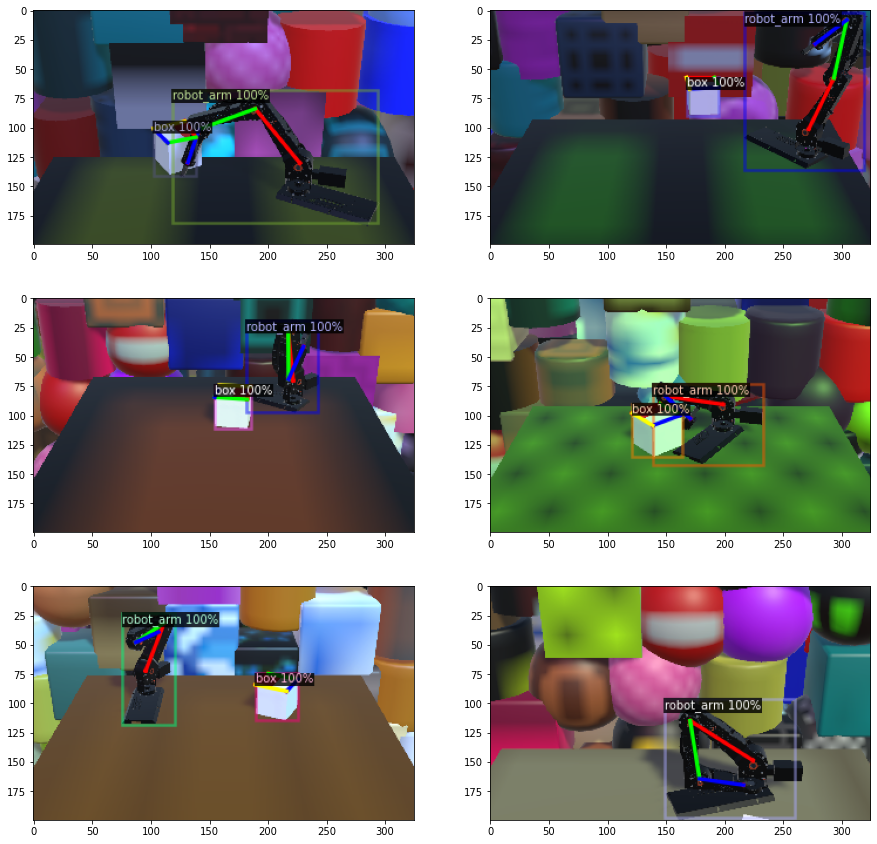

In [17]:
# Visualize predictions on synthetic test data
visualize_predictions(synth_data, synth_metadata_test, save_fig=True)

In [10]:
from detectron2.data.datasets import convert_to_coco_json 
convert_to_coco_json("dataset_test", os.path.join(output_dir, "dataset_test_coco_format.json"), allow_cached=False)

[06/10 14:23:14 d2.data.datasets.coco]: Converting annotations of dataset 'dataset_test' to COCO format ...)
[06/10 14:23:14 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/10 14:23:14 d2.data.datasets.coco]: Conversion finished, #images: 200, #annotations: 396
[06/10 14:23:14 d2.data.datasets.coco]: Caching COCO format annotations at './output/dataset_test_coco_format.json' ...


In [11]:
# Evaluate prediction performance (AP) with COCOEvaluator
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

evaluator = COCOEvaluator("dataset_test", ("bbox", "keypoints"), False, output_dir=output_dir, kpt_oks_sigmas=oks_sigmas)
val_loader = build_detection_test_loader(cfg, "dataset_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[06/10 14:23:14 d2.evaluation.coco_evaluation]: Trying to convert 'dataset_test' to COCO format ...
WARNING [06/10 14:23:14 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/dataset_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[06/10 14:23:14 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
| robot_arm  | 200          |    box     | 196          |
|            |              |            |              |
|   total    | 396          |            |              |
[06/10 14:23:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/10 14:23:14 d2.data.common]: Serializing 200 elements to byte tensors and concatenating them all ...
[06/10 14:23:14 d2.data.common]: Se

### Evaluate model on real data

In [12]:
# Get test dataset and corresponding metadata
real_data = return_dataset("real")
real_metadata = MetadataCatalog.get("dataset_real")

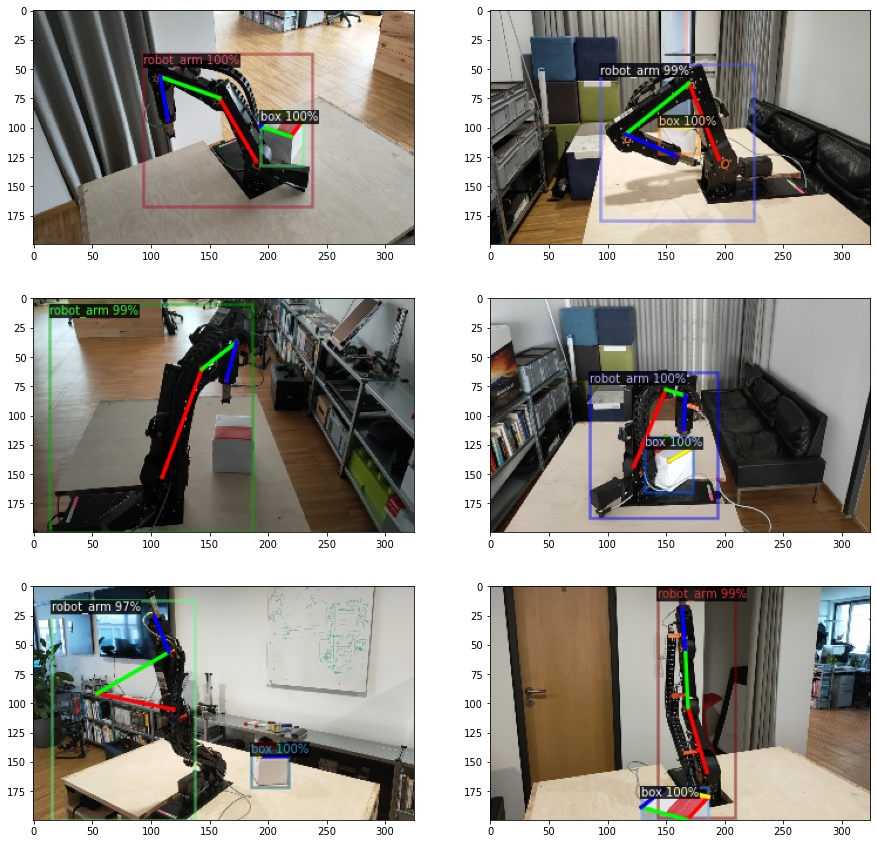

In [16]:
visualize_predictions(real_data, real_metadata, save_fig=True)

In [14]:
convert_to_coco_json("dataset_real", os.path.join(output_dir, "dataset_real_coco_format.json"), allow_cached=False)

[06/10 14:23:31 d2.data.datasets.coco]: Converting annotations of dataset 'dataset_real' to COCO format ...)
[06/10 14:23:31 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/10 14:23:31 d2.data.datasets.coco]: Conversion finished, #images: 150, #annotations: 300
[06/10 14:23:31 d2.data.datasets.coco]: Caching COCO format annotations at './output/dataset_real_coco_format.json' ...


In [15]:
evaluator = COCOEvaluator("dataset_real", ("bbox", "keypoints"), False, output_dir=output_dir, kpt_oks_sigmas=oks_sigmas)
val_loader = build_detection_test_loader(cfg, "dataset_real")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[06/10 14:23:31 d2.evaluation.coco_evaluation]: Trying to convert 'dataset_real' to COCO format ...
WARNING [06/10 14:23:31 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/dataset_real_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[06/10 14:23:31 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
| robot_arm  | 150          |    box     | 150          |
|            |              |            |              |
|   total    | 300          |            |              |
[06/10 14:23:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/10 14:23:31 d2.data.common]: Serializing 150 elements to byte tensors and concatenating them all ...
[06/10 14:23:31 d2.data.common]: Se